# Классификация, детекция.

## Классификация

Обучим классификатор изображений. Будем работать с датасетом, в котором 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы от 0 до 199.

Структура датасета простая - есть директории train и val, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат собственно сами изображения.

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt

from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, Normalize, ToTensor, Compose

import glob

Прочитаем данные, создадим даталоадеры, применим аугментацию:

In [ ]:
train_dataset = ImageFolder("./dataset/dataset/train", transform=Compose([Resize((224, 224)), ToTensor(), Normalize((0.5, 0.5, 0.5), (1, 1, 1)), ]))
val_dataset = ImageFolder("./dataset/dataset/val", transform=Compose([Resize((224, 224)), ToTensor(), Normalize((0.5, 0.5, 0.5), (1, 1, 1)), ]))

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=True)

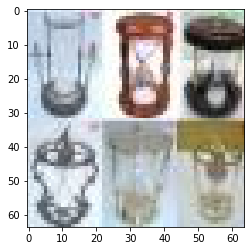

In [ ]:
file = np.random.choice(glob.glob("./dataset/dataset/train/*/*.jpg"))
plt.imshow(plt.imread(file))

Напишем функции `fit` и `predict`

In [ ]:
import tqdm
from sklearn.metrics import accuracy_score

def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model = model.to(device).train()
    all_losses = np.array([]) 
    total_predictions = np.array([]) 
    total_labels = np.array([])
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        predicted = model(images) 
        loss = criterion(predicted, labels) 
        loss.backward()
        optimizer.step() 
        optimizer.zero_grad() 
        total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy()) 
        total_labels = np.append(total_labels, labels.cpu().detach().numpy()) 
        all_losses = np.append(all_losses, loss.detach().item()) 

    accuracy_train = accuracy_score(total_labels, total_predictions)
    print(f"Accuracy_epoch_train: {round(accuracy_train * 100, 4)} ") 

    return all_losses 

def predict(model, val_dataloader, criterion, device="cuda:0"):
    model = model.eval()
    model.to(device)
    predicted_classes = np.array([]) 
    actual_classes = np.array([]) 
    losses = np.array([]) 
    for images, labels in val_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        predicted = model(images) 
        loss = criterion(predicted, labels)
        predicted_classes = np.append(predicted_classes, predicted.argmax(1).cpu().detach().numpy()) 
        actual_classes = np.append(actual_classes, labels.cpu().detach().numpy()) 
        losses = np.append(losses, loss.item()) 

    accuracy_val = accuracy_score(actual_classes, predicted_classes) 
    print(f"Accuracy_epoch_val: {round(accuracy_val * 100, 4)} ") 
    return losses, predicted_classes, actual_classes


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    from tqdm import tqdm
    model.to(device)
    LOSS_train = [] 
    LOSS_val = [] 
    for epoch in tqdm(range(n_epochs)):
        train_loss =  train_one_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            criterion=criterion
        )

        LOSS_train.extend(train_loss) 

        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            val_loss,_,_ = predict(
                model=model,
                val_dataloader=val_dataloader,
                criterion=criterion
            )
        LOSS_val.extend(val_loss) 

    fig, axs = plt.subplots(2, figsize = (10,12))
    n_train = np.arange(1, len(LOSS_train)+ 1)
    n_val = np.arange(1, len(LOSS_val)+ 1)

    axs[0].plot(n_train, LOSS_train)
    axs[0].set_title('Train Loss')
    axs[0].set_ylabel('Loss')
    axs[1].plot(n_val, LOSS_val)
    axs[1].set_title('Validation Loss')
    axs[1].set_xlabel('iterations')
    axs[1].set_ylabel('Loss')

Зададим модель, optimizer, criterion.

Возъмём предобученный ResNet и обучим последний линейный слой.

In [ ]:
from torchvision.models import resnet18

model = resnet18(pretrained=True)

for p in model.parameters():
    p.requires_grad = False

model.fc = nn.Linear(512, 200)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
optimizer = torch.optim.Adam(model.fc.parameters(), 1e-4)
criterion = nn.CrossEntropyLoss()
n_epochs = 5 
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

### Обучение модели и графики

  0%|          | 0/5 [00:00<?, ?it/s]

Accuracy_epoch_train: 19.885 
Validation Epoch: 0


 20%|██        | 1/5 [05:07<20:29, 307.47s/it]

Accuracy_epoch_val: 38.11 
Accuracy_epoch_train: 44.535 
Validation Epoch: 1


 40%|████      | 2/5 [10:12<15:20, 306.72s/it]

Accuracy_epoch_val: 48.55 
Accuracy_epoch_train: 51.223 
Validation Epoch: 2


 60%|██████    | 3/5 [15:16<10:11, 305.89s/it]

Accuracy_epoch_val: 52.0 
Accuracy_epoch_train: 54.14 
Validation Epoch: 3


 80%|████████  | 4/5 [20:19<05:05, 305.15s/it]

Accuracy_epoch_val: 53.89 
Accuracy_epoch_train: 55.917 
Validation Epoch: 4


100%|██████████| 5/5 [25:24<00:00, 304.94s/it]

Accuracy_epoch_val: 55.27 


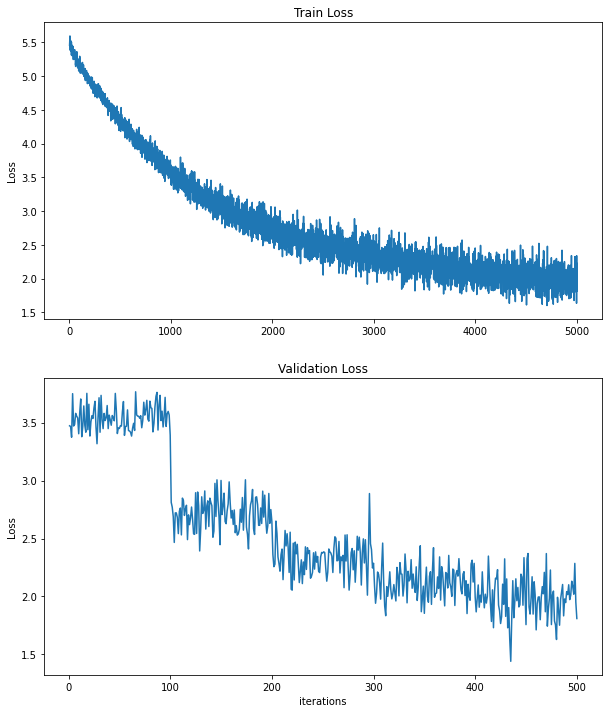

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler=None)

In [ ]:
all_losses, predicted_labels, actual_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(actual_labels, predicted_labels)
print('Accuracy = {}'.format(accuracy))

Таким образом, accuracy составляет 0.5514

Модель показывает устойчивое обучение на train (loss снижается постепенно).
Loss на test снижается с каждой эпохой (наблюдаются резкие падения после каждого 100-го объекта, так как в каждой эпохе их 100). 

Создание и обучение новой модели с нуля для большого датасета - это достаточно долго. Именно поэтому было решено использовать fine-tuning. Предобученная модель ResNet18 уже умеет распознавать паттерны на картинках, достаточно было обучить последний линейный слой для корректировки на данный датасет. Качество получилось достаточно высоким. 

## Object detection.

Обучим детектор фруктов на изображении.

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
! pip install xmltodict

In [ ]:
import xmltodict, json

In [ ]:
torch.random.initial_seed()  
torch.cuda.manual_seed_all(8)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Напишем собственный класс датасета.

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import xmltodict
import json
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc

class2tag = {"apple": 1, "orange": 2, "banana": 3}


class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

Применим аугментацию.

In [ ]:
import albumentations as A
import cv2
from albumentations.pytorch.transforms import ToTensor

In [ ]:
def get_transform(train):
    if train:
        return A.Compose([
                            A.RandomBrightnessContrast(p=0.2), 
                            A.HorizontalFlip(0.5),
                            ToTensor() 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}) 
    else:
        return A.Compose([
                            A.HorizontalFlip(0.5), 
                            ToTensor()
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

Напишем функции `train_one_epoch` и `train`

In [ ]:
def train_one_epoch(model, train_dataloader, optimizer, device):
    model.train()
    n = 0
    global_loss = 0 #будем считать лосс
    for images, targets in train_dataloader:
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets) 
        losses = sum(loss for loss in dict_loss.values()) 

        optimizer.zero_grad() 
        losses.backward() 
        optimizer.step() 

        n += 1
        global_loss += float(losses.cpu().detach().numpy()) 

        if n % 10 == 0:
            print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))

    return global_loss


def train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=10):
    for epoch in range(n_epochs):
        model.eval()
        a = evaluate(model, val_dataloader, device=device)
        print("AUC ON TEST: {}".format(round(float(a), 4)))
        model.train()
        train_one_epoch(model, train_dataloader, optimizer, device=device)

Faster R-CNN

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [ ]:
def get_detection_model(num_classes=3):
    model = fasterrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

Создадим датасеты и даталоадеры

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
torch.random.initial_seed()  
torch.cuda.manual_seed_all(8)

dataset_train = FruitDataset('./train_zip/train/', transform=get_transform(train=True)) 
dataset_val = FruitDataset('./test_zip/test/', transform=get_transform(train=False))

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)

dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn)

Обучим модель

In [ ]:
n_epochs = 5
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model = get_detection_model(4)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

train(model, dataloader_train, dataloader_val, optimizer, device, n_epochs)

AUC ON TEST: 0.0003
Loss value after 10 batches is 0.67
Loss value after 20 batches is 0.56
Loss value after 30 batches is 0.49
Loss value after 40 batches is 0.45
Loss value after 50 batches is 0.42
Loss value after 60 batches is 0.39
Loss value after 70 batches is 0.38
Loss value after 80 batches is 0.35
Loss value after 90 batches is 0.35
Loss value after 100 batches is 0.34
Loss value after 110 batches is 0.33
Loss value after 120 batches is 0.32
AUC ON TEST: 0.8152
Loss value after 10 batches is 0.22
Loss value after 20 batches is 0.2
Loss value after 30 batches is 0.2
Loss value after 40 batches is 0.19
Loss value after 50 batches is 0.2
Loss value after 60 batches is 0.21
Loss value after 70 batches is 0.21
Loss value after 80 batches is 0.2
Loss value after 90 batches is 0.19
Loss value after 100 batches is 0.2
Loss value after 110 batches is 0.19
Loss value after 120 batches is 0.19
AUC ON TEST: 0.9033
Loss value after 10 batches is 0.17
Loss value after 20 batches is 0.15
Los

### Итоговое качество модели

In [ ]:
auc = evaluate(model, dataloader_val, device)

Таким образом, AUC = 0.89

Нарисуем предсказанные боксы для картинок из тестового датасета

In [ ]:
image, labels = next(iter(dataset_val))
pred = model(image.unsqueeze(0).to(device))[0]

In [ ]:
i = 0
images_s = []
labels_s = []
preds = []
for image, labels in dataset_val:
  images_.append(image)
  labels_.append(labels)
  preds.append(model(image.unsqueeze(0).to(device))[0])
  i += 1
  if i >= 2:
    break

In [ ]:
image1 = images_s[0]
labels1 = labels_s[0]
pred1 = preds[0]
image2 = images_s[1]
labels2 = labels_s[1]
pred2 = preds[1]

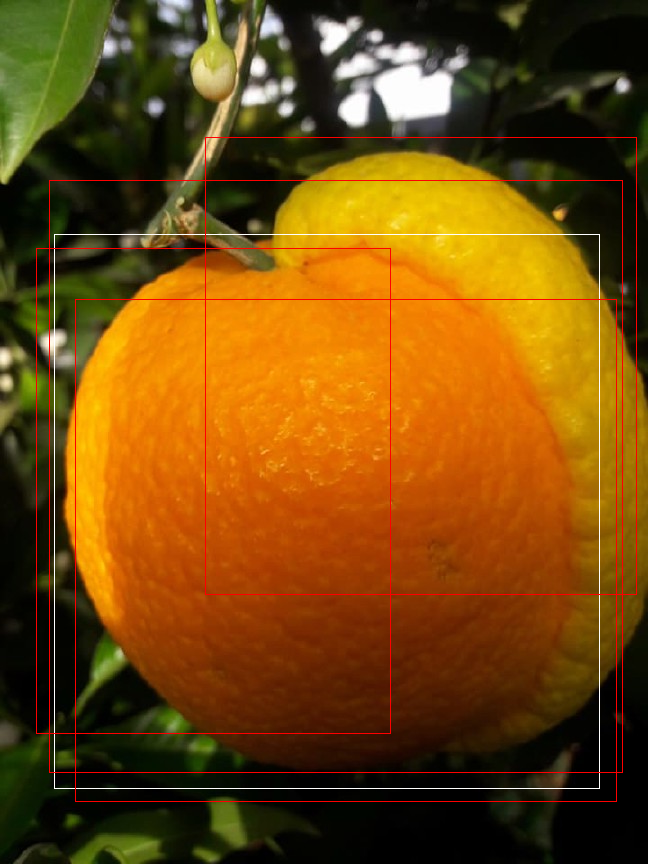

In [ ]:
from PIL import ImageDraw

image = torchvision.transforms.ToPILImage()(image1)
draw = ImageDraw.Draw(image)
for box in labels1['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred1['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

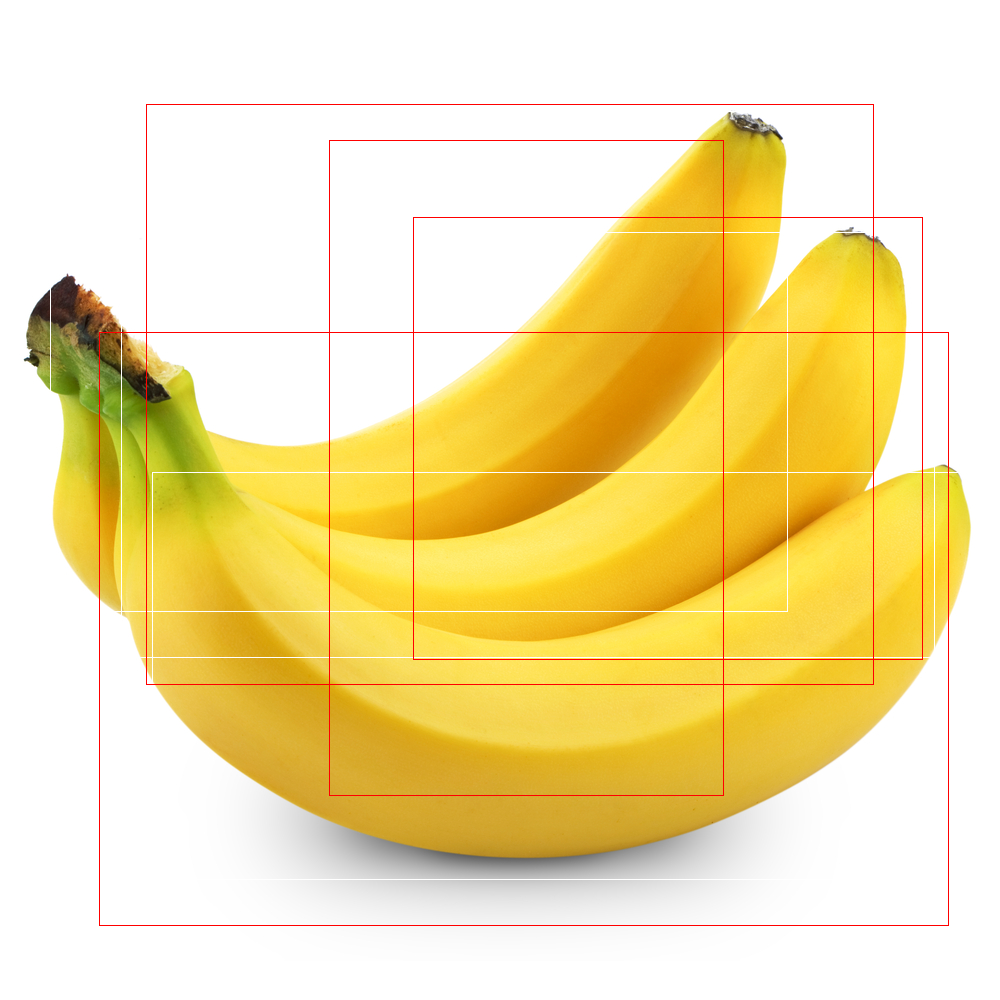

In [ ]:
image = torchvision.transforms.ToPILImage()(image2)
draw = ImageDraw.Draw(image)
for box in labels2['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred2['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

Модель Faster R-CNN показывает отличные показатели метрики IoU (> 90%), это говорит об ее высоком качестве. Примеры качества видны на двух картинках, нарисованных выше.